## Acknowledgements

This notebook was originally prepared by Dr. Simone Rossi, who has been a Ph.D. student and then a Postdoctoral Researcher at Eurecom.

In [56]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from tqdm.notebook import tqdm 

import matplotlib
from matplotlib import rc

rc("font", **{"family": "sans-serif", "sans-serif": "DejaVu Sans"})
rc("figure", **{"dpi": 200})
rc(
    "axes",
    **{"spines.right": False, "spines.top": False, "xmargin": 0.0, "ymargin": 0.05}
)

In [57]:
df = pd.read_csv('public/train.csv', low_memory=True)

In [58]:
df_test = pd.read_csv('public/test_feat.csv', low_memory=True)

In [59]:
df.head()

,index,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,...,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next,fact_temperature
0,0,1.538665e+09,42.696693,23.411436,532.0,11.436109,15.718571,694.970318,279.984589,10.375,...,0.0,0.0,0.0,0.0,0.0,0.058990,0.808984,0.0,0.0,19.0
1,1,1.539436e+09,51.447778,4.341944,20.0,26.956421,12.511429,759.973131,288.606445,8.375,...,0.0,0.0,0.0,0.0,0.0,0.348022,16.150018,0.0,0.0,25.0
2,2,1.541235e+09,39.175400,-76.668297,42.0,-45.928553,10.842857,759.321626,284.499634,1.125,...,0.0,0.0,0.0,0.0,0.0,-1.500000,5.950006,0.0,100.0,11.0
3,3,1.544501e+09,36.029598,-119.063004,132.0,-25.871600,15.259286,754.582732,278.388733,2.500,...,0.0,0.0,0.0,0.0,0.0,0.299988,6.450006,0.0,0.0,9.0
4,4,1.538634e+09,34.398300,-96.148102,179.0,-61.020501,20.564286,744.448625,294.560196,3.250,...,0.0,0.0,0.0,0.0,0.0,-0.500000,20.749994,0.0,0.0,23.0


In [60]:
df_test.head()

,index,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,...,cmc_0_1_66_0_grad,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next
0,1993574,1.547967e+09,33.466499,-82.039398,129.0,-74.604821,7.053571,756.861547,286.466949,0.875,...,0.0000,0.00000,0.0,0.0,0.0,0.0,-3.000000,8.150018,-48.0,1.0
1,1993575,1.550765e+09,-3.552530,-80.381401,26.0,68.688172,24.221429,754.893806,296.029541,2.625,...,0.0000,0.00000,0.0,0.0,0.0,0.0,0.291351,22.141351,2.0,2.0
2,1993576,1.537093e+09,59.878899,-1.295560,2.0,26.380551,11.789286,756.023981,284.402039,1.125,...,0.0000,0.00000,0.0,0.0,0.0,0.0,-1.100006,10.249994,8.0,91.0
3,1993577,1.548846e+09,39.048801,-84.667801,263.0,-29.799833,0.808571,743.716901,252.938766,7.125,...,0.1661,1.27641,0.0,0.0,0.0,0.0,-0.795135,-26.294791,26.0,29.0
4,1993578,1.547161e+09,32.566700,-117.116997,6.0,27.294687,14.082143,762.318629,284.741882,3.125,...,0.0000,0.00000,0.0,0.0,0.0,0.0,0.702820,13.571649,0.0,0.0


# Data analysis

In this challenge, you are free (and encouraged) to explore in depth the data you have, you can run simple queries on the data, perform exploration and compute statistics.

**NOTE**: finding the right question to ask is difficult! Don't be afraid to complement your analysis with your own questions. This can give you extra points!

**NOTE 2**: the presentation quality is critical in any business-oriented data analysis. Take time to create few but informative plots, rather than endless tables! 

In [61]:
tr_coordinates = df[['fact_latitude','fact_longitude']].drop_duplicates()
te_coordinates = df_test[['fact_latitude','fact_longitude']].drop_duplicates()

In [62]:
merged = te_coordinates.merge(tr_coordinates, how='left', indicator=True)
tropic_coordinates = merged[merged['_merge']=='left_only']
common_coordinates = merged[merged['_merge']=='both']

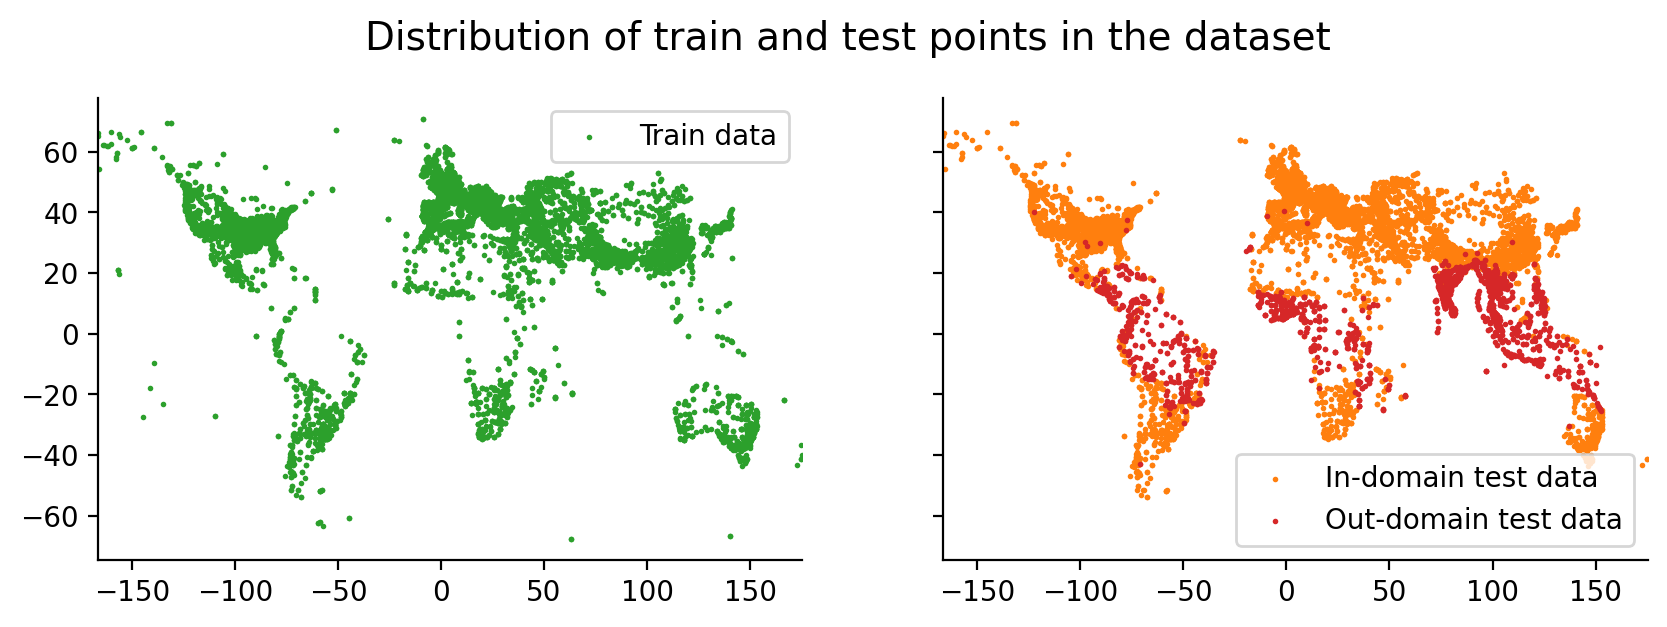

In [63]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 3], dpi=200, sharex=True, sharey=True)
ax0.scatter(tr_coordinates['fact_longitude'], tr_coordinates['fact_latitude'], 
            s=1, c='tab:green', label='Train data')
ax1.scatter(common_coordinates['fact_longitude'], common_coordinates['fact_latitude'], 
            s=1, c='tab:orange', label='In-domain test data')
ax1.scatter(tropic_coordinates['fact_longitude'], tropic_coordinates['fact_latitude'], 
            s=1, c='tab:red', label='Out-domain test data')
ax0.legend(), ax1.legend()
fig.suptitle('Distribution of train and test points in the dataset', y=1.01, fontsize=14)
plt.show()

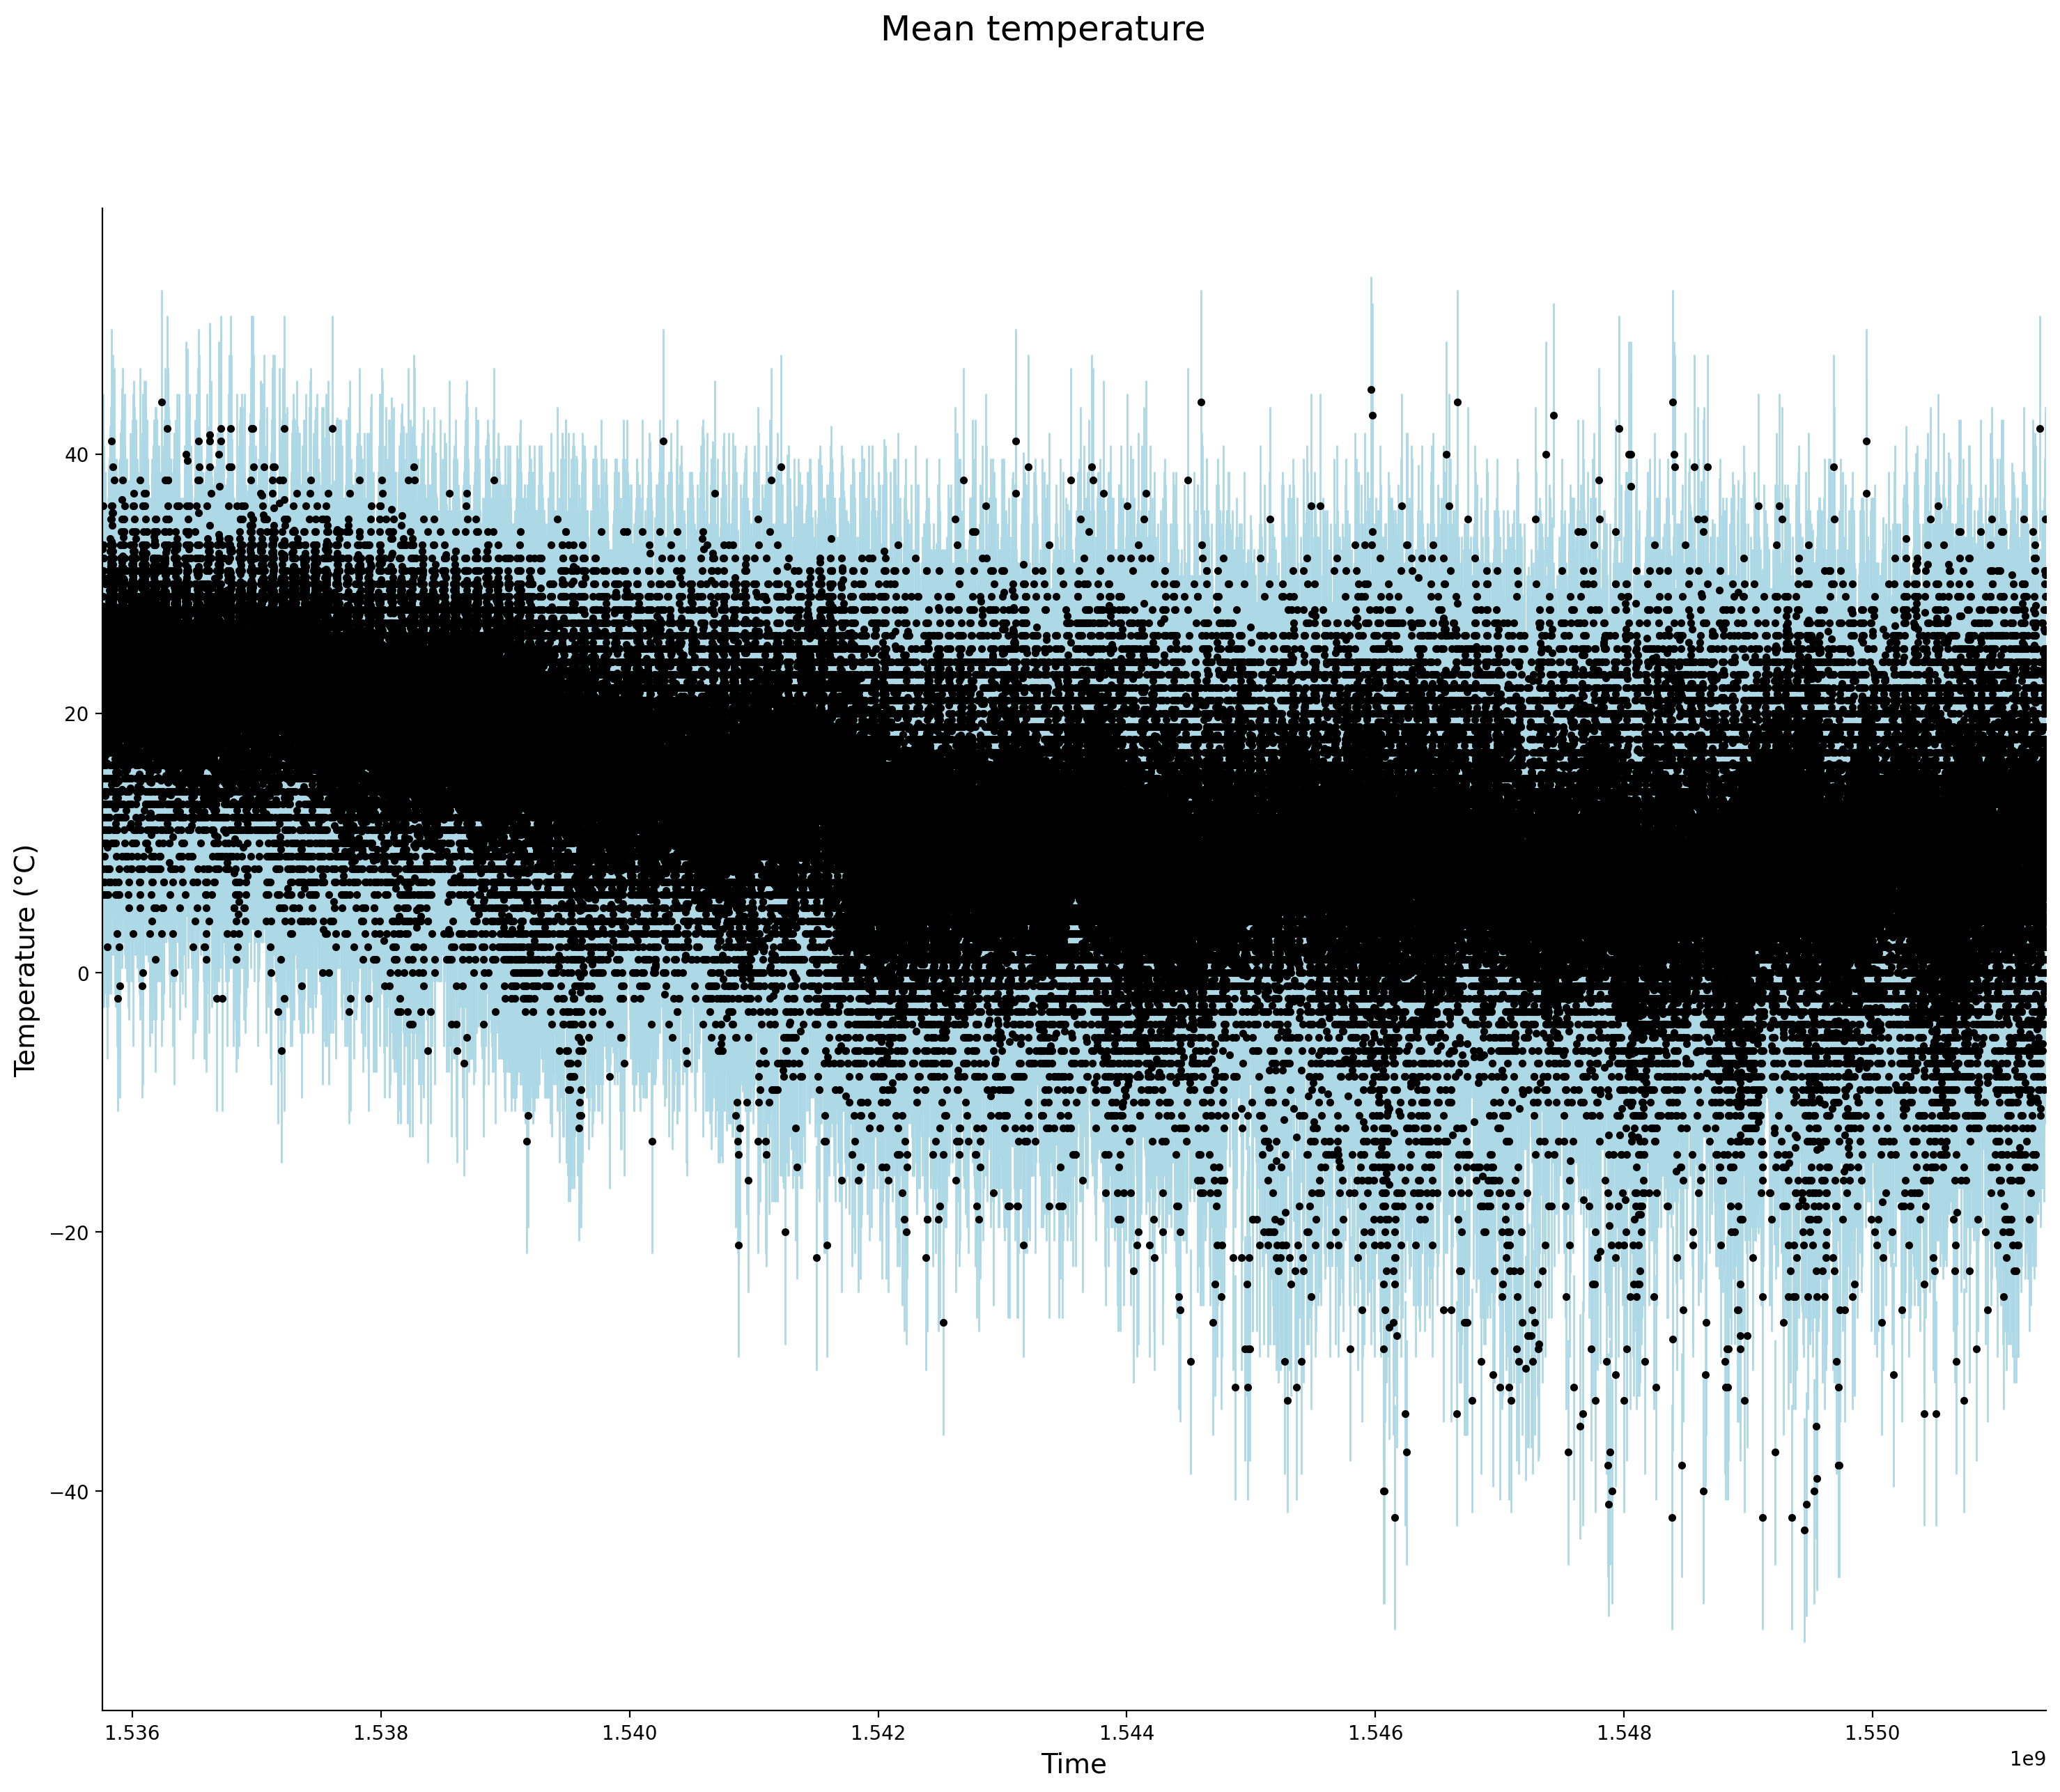

In [64]:
mean_temps = df.groupby(df.fact_time).mean()

plt.rcParams['figure.figsize'] = [18, 14]

plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.errorbar(mean_temps.index, mean_temps.fact_temperature, yerr=mean_temps.fact_temperature.std(), 
             fmt='.', color='black', ecolor='lightblue', elinewidth=1)
plt.suptitle('Mean temperature', fontsize=18)
plt.show()


# Data Pre-processing

The previous step should give you a better understanding of which pre-processing is required for the data. This may include:

-    Normalising and standardising the given data;
-    Removing outliers;
-    Carrying out feature selection, possibly using metrics derived from information theory;
-    Handling missing information in the dataset;
-    Augmenting the dataset with external information;
-    Combining existing features.

Below is a very basic example of pre-processing steps.


In [65]:
'''
Sorting by time, because when we split in train and validation sets 
we need to do a split in time. This is because if we have overlapping time
periods, we may overfit without being able to detect it in valdation. So the
first part (in time) of the data needs to be used for training and the second
for validation.
'''
df = df.sort_values(by=['fact_time'], ascending=False)

df.head()

,index,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_6_2,cmc_0_0_7_1000,...,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next,fact_temperature
353021,353021,1.551395e+09,34.733601,-76.660599,0.0,9.023691,12.278571,764.197433,285.997162,1.750,...,0.00000,0.0,0.000000,0.0,0.000000,-0.184875,8.628168,0.0,0.0,9.0
1175290,1175290,1.551395e+09,43.043598,-115.872002,911.0,30.509222,6.107143,696.746357,271.437759,9.750,...,0.12484,0.0,0.556420,0.0,0.000000,-0.314484,-4.359473,30.0,63.0,7.0
1558948,1558948,1.551395e+09,34.733601,-76.660599,0.0,9.023691,12.278571,764.197433,285.971375,1.250,...,0.00000,0.0,0.000000,0.0,0.000000,-0.529236,8.820764,-4.0,40.0,9.0
1345151,1345151,1.551395e+09,32.332600,-88.751900,88.0,19.318177,12.684286,754.283904,290.471375,2.625,...,0.00000,0.0,0.000000,0.0,0.000000,-0.529266,15.520746,-23.0,26.0,22.0
430756,430756,1.551395e+09,39.701698,-104.751999,1700.0,26.797451,3.592857,626.046512,273.081161,10.000,...,0.00000,0.0,0.283972,0.0,0.107304,6.195068,-0.800055,0.0,0.0,11.0


In [66]:
col_selection = []
col_selection_test = []

for c in df.columns:
    if c not in ['fact_temperature']:
        col_selection.append(c)
        col_selection_test.append(c)
col_selection +=['fact_temperature']


In [67]:
X = df[col_selection].dropna().iloc[:, 1:-1].values
y = df[col_selection].dropna().iloc[:, -1].values

In [68]:
Xmean, Xstd, ymean, ystd = X.mean(0), X.std(0), y.mean(), y.std()

# Create a boolean mask to identify columns with standard deviation of 0
zero_std_mask = Xstd == 0

# Filter out the columns with standard deviation of 0
X_filtered = X[:, ~zero_std_mask]
Xstd = Xstd[~zero_std_mask]
Xmean = Xmean[~zero_std_mask]

X = (X_filtered - Xmean) / Xstd
y = (y - ymean) / ystd


# Model Selection

Perhaps one of the most important segments of this challenge involves the selection of a model that can successfully handle the given data and yield sensible predictions. Instead of focusing exclusively on your final chosen model, it is also important to share your thought process in this notebook by additionally describing alternative candidate models. There is a wealth of models to choose from, such as decision trees, random forests, (Bayesian) neural networks, Gaussian processes, Lasso regression, and so on. There are several factors which may influence your decision:

-    What is the model's complexity?
-    Is the model interpretable?
-    Is the model capable of handling different data-types?
-    Does the model return uncertainty estimates along with predictions?

In this baseline solution, we use the Lasso regression model, which is a linear least-square model with L1 regularization on its parameters. There is a hyper-parameter that should be tuned which is the regularization strength α. Intuitively, this hyper-parameter controls the amount of shrinkage of the parameters of the model: the larger the value of α the greater the amount of shrinkage.

Section 3.4.1 of the book The Elements of Statistical Learning: Data Mining, Inference, and Prediction from Trevor Hastie et al. (https://hastie.su.domains/Papers/ESLII.pdf) is a good reference for some classic regression models.

In [69]:
from sklearn.model_selection import train_test_split
Xtr, Xval, ytr, yval = train_test_split(X, y, random_state=None, test_size=10000, shuffle=False)

In [70]:
from sklearn.linear_model import Ridge

def compute_rmse(y, ypred, ystd=1.):
    return np.mean((y - ypred)**2)**0.5 * ystd

In [71]:
ridge_model = Ridge(alpha=1)
ridge_model.fit(Xtr, ytr)
ypred_tr = ridge_model.predict(Xtr)
ypred_val = ridge_model.predict(Xval)

print(f'Train RMSE: {compute_rmse(ytr, ypred_tr, ystd):.3f}')
print(f'Valid RMSE: {compute_rmse(yval, ypred_val, ystd):.3f}')

Train RMSE: 2.280
Valid RMSE: 2.264


# Parameter Optimisation

Irrespective of your choice, it is highly likely that your model will have one or more parameters that require tuning. There are several techniques for carrying out such a procedure, including cross-validation, Bayesian optimisation, and several others. As before, an analysis into which parameter tuning technique best suits your model is expected before proceeding with the optimisation of your model.

The below cells demonstrate tuning the hyper-parameters α of the Ridge regression model by using cross-validation.

In [72]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [73]:
import numpy as np

def get_cv_idx(n, test_size=0.2, n_splits=2):
    train_idx, test_idx = [], []
    for _ in range(n_splits):
        idx = np.random.permutation(n)
        train_size = int(n * (1 - test_size)) if isinstance(test_size, float) else n - test_size
        train_idx.append(idx[:train_size])
        test_idx.append(idx[train_size:])
    return train_idx, test_idx

In [74]:
train_idx, cv_idx = get_cv_idx(len(Xtr), test_size=10000, n_splits=10)

In [75]:
param_grid = {
    "alpha": [0.001, 0.01, 0.1, 1, 10]
}

search = GridSearchCV(ridge_model, 
                      param_grid,
                      n_jobs=1, 
                      verbose=1,
                      cv=zip(train_idx, cv_idx), 
                      scoring='neg_root_mean_squared_error').fit(Xtr, ytr)

print('Done!')

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Done!


In [76]:
print("Best parameters set found on cv set:")
print(search.best_params_)
print()
print("Grid scores on cv set:")
means = search.cv_results_["mean_test_score"]
stds = search.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, search.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (-mean * ystd, (std * ystd) * 2, params))
print()
print("Error on the validation set:")
ypred_val = search.predict(Xval)
print(f'Valid RMSE: {compute_rmse(yval, ypred_val, ystd):.3f}')

Best parameters set found on cv set:
{'alpha': 0.1}

Grid scores on cv set:
2.284 (+/-0.039) for {'alpha': 0.001}
2.284 (+/-0.039) for {'alpha': 0.01}
2.284 (+/-0.039) for {'alpha': 0.1}
2.284 (+/-0.039) for {'alpha': 1}
2.284 (+/-0.039) for {'alpha': 10}

Error on the validation set:
Valid RMSE: 2.263


# Model Evaluation

Some form of pre-evaluation will inevitably be required in the preceding sections in order to both select an appropriate model and configure its parameters appropriately. In this final section, you may evaluate other aspects of the model such as:

-    Assessing the running time of your model;
-    Determining whether some aspects can be parallelised;
-    Training the model with smaller subsets of the data.
-    etc.

Remember, the goal of this challenge is to construct a model for predicting the temperature around the globe.



In [77]:
df_test = pd.read_csv('public/test_feat.csv', low_memory=True)

In [78]:
Xte = df_test[col_selection_test].iloc[:, 1:].values
Xte = Xte[:, ~zero_std_mask]
Xte = (Xte - Xmean) / Xstd

In [79]:
ypred_te = search.predict(Xte) * ystd + ymean  # Remember to un-standardize the predictions


# Submission
Your submission is a CSV file containing your final model's predictions on the given test data. This file should contain a header and have the following format:

```
index,fact_temperature
1993574,3.9865149124872303
1993575,18.165092058370533
1993576,16.53315442160854
1993577,8.377598784006866
...
```

A leaderboard for this challenge will be ranked using the root mean squared error between the predicted values and the observed arrival delays. However, you can use other metrics for regression tasks in your presentation notebook to evaluate many aspects of your model, including quantification of the uncertainty in the predictions.

Below is an example of creating a submission file.


In [80]:
submission_df = pd.DataFrame(data={'index': df_test['index'].values,
                                   'fact_temperature': ypred_te.squeeze()})

# Save the predictions into a csv file
# Notice that this file should be saved under the directory `/kaggle/working` 
# so that you can download it later
submission_df.to_csv("submission.csv", index=False)

In [81]:
# Check the submission file
! head -6 "submission.csv"

index,fact_temperature
1993574,13.536383868075262
1993575,28.98427570695589
1993576,13.891691774258447
1993577,-15.92470435149355
1993578,15.681229318056864
